In [178]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import seaborn as sns
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('dark_background')
sns.set()

### Functions

In [97]:
def nucl_lists():
    """
    Generate lists of possible nucleotides
    
    Outputs:
    di_list - list of possible dinuclotides
    tri_list - list of possible trinuclotides
    tetra_list - list of possible tetranuclotides
    """
    
    nucl = ["A","T","C","G"]
    di_list = [i+j for i in nucl for j in nucl]
    tri_list = [i+j for i in di_list for j in nucl]
    tetra_list = [i+j for i in tri_list for j in nucl]

    return (di_list, tri_list, tetra_list)
  
    
def rev_comp(string):
    """
    Return reverse complement of DNA strand
    
    Input - sequence
    
    Output - reverse complement
    """
    
    complementary = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 
    comp = ''
    for i in string:
        comp += complementary[i]

    return comp[::-1]

    
def count_occurrences(subsequence, sequence):
    """
    Count occurrences of substring in a string
    (including overlaping substrings)
    
    Inputs:
    sequence - sequence
    subsequence - subsequence to be found in sequence
    
    Output: number of occurrences of subsequence in sequence
    """
    number_of_occurrences = 0
    for i in range(len(sequence)):
        if sequence[i:i+len(subsequence)] == subsequence:
            number_of_occurrences += 1
            
    return number_of_occurrences


def get_frequencies(sequence):
    """
    Count occurrences of oligonuclotides in sequence
    
    Input - sequence
    
    Output - array of tetranuclotides counts
    """
    encoding = {'A':0, 'T':1, 'C':2, 'G':3}
    
    seq = np.zeros(4)
    tetra_freq = np.ones(256)
    
    non_nucl = 0
    
    n = 1
    for i in sequence:

        if i in ['A','T','C','G']:
            seq[0] = seq[1]
            seq[1] = seq[2]
            seq[2] = seq[3]
            seq = seq*4
            seq[3] = encoding[i]

            if n > 3:
                tetra_freq[int(seq.sum())] += 1
            n +=1
            
        else:
            non_nucl += 1 
    
    if non_nucl > 0:
        print("Warning: %i characters other than A T C G found" % non_nucl)
    return(tetra_freq)


def get_23(tetra_list, tetra_freq, tri_list, di_list):
    """
    Extract tri and di nucleotides frequencies 
    from tetranucleotides frequencies 
    
    imputs:
    di_list - list of possible dinuclotides
    tri_list - list of possible trinuclotides
    tetra_list - list of possible tetranuclotides
    tetra_freq - array of tetranuclotides counts
    
    Outputs:
    tri_nucl - dictionary of trinuclotides frequency
    di_nucl - dictionary of dinuclotides frequency
    """
    #Calculate 3 and 2-mers based on 4-mers
    di_nucl = {di_list[i]:0 for i in range(len(di_list))}
    tri_nucl = {tri_list[i]:0 for i in range(len(tri_list))}
    
    for i in range(len(tetra_list)):
        tri_nucl[tetra_list[i][0:3]] += tetra_freq[i]
    
    for i in tri_nucl:
        di_nucl[i[0:2]] += tri_nucl[i]

    return(tri_nucl, di_nucl)


def rev_comp_freq(oligo_list, oligo_freq):
    """
    Calculate frequencies of oligonuclotides from the complementary strand
    
    Inputs:
    oligo_list - list of oligonuclotides
    oligo_freq - list of oligonuclotides counts
    
    Output - updated frequencies
    """
    
    r_dir = {oligo_list[i]:oligo_freq[i] for i in range(len(oligo_list))}
    
    for i in range(len(oligo_list)):
        oligo_freq[i] += r_dir[rev_comp(oligo_list[i])]
    
    return oligo_freq


def exp_tnf(tetra_list, tri_nucl, di_nucl):
    """
    Calculate expected tetranucleotide frequency
    
    Inputs:
    tetra_list - list of tetranuclotides
    tri_nucl - dictionary of trinuclotides frequency
    di_nucl - dictionary of dinuclotides frequency
    
    Output: expected tetranuclotide frequency
    """
    
    expected_tnf = np.zeros(len(tetra_list))
    for i in range(len(tetra_list)):
        tn = tetra_list[i]
        expected_tnf[i] = (tri_nucl[tn[0:3]]*tri_nucl[tn[1:4]])/di_nucl[tn[1:3]]
            
    return expected_tnf


def app_variance(expected_tnf, tetra_list, tri_nucl, di_nucl):
    """
    Approximated variance of tetranuclotide frequency
    
    Inputs:
    expected_tnf - expected tetranuclotide frequency
    tetra_list - list of tetranuclotides
    tri_nucl - dictionary of trinuclotides frequency
    di_nucl - dictionary of dinuclotides frequency
    
    Output - approximated variance of tetranuclotide frequency
    """
    
    app_var = np.zeros(len(tetra_list))
    for i in range(len(tetra_list)):
        tn = tetra_list[i]
        n23 = di_nucl[tn[1:3]]
        n123 = tri_nucl[tn[0:3]]
        n234 = tri_nucl[tn[1:4]]
        app_var[i] = expected_tnf[i] * (((n23-n123)*(n23-n234))/(n23*n23))
            
    return app_var


def tnf_z_score(tetra_freq, expected_tnf, app_var):
    """
    Calculate tetranuclotide z-score
    
    Inputs:
    tetra_freq - observed tetranuclotide frequency
    expected_tnf - expected tetranuclotide frequency
    app_var - approximated variance of tetranuclotide frequency
    
    Output - tetranuclotide z-score
    """
    
    z_scores = (tetra_freq-expected_tnf)/np.sqrt(app_var)
    return z_scores


def get_z_scores(sequence, di_list, tri_list, tetra_list):
    """
    Calculate z-scores from sequence
    
    Inputs:
    sequence - DNA sequence
    di_list - list of possible dinuclotides
    tri_list - list of possible trinuclotides
    tetra_list - list of possible tetranuclotides
    
    Output - np array of z-scores
    """
    
    tetra_freq = get_frequencies(sequence)
    tetra_freq = rev_comp_freq(tetra_list, tetra_freq)
    tri_nucl, di_nucl = get_23(tetra_list, tetra_freq, tri_list, di_list)
    
    expected_tnf = exp_tnf(tetra_list, tri_nucl, di_nucl)
    app_var = app_variance(expected_tnf, tetra_list, tri_nucl, di_nucl)
    z_scores = tnf_z_score(tetra_freq, expected_tnf, app_var)
    
    return z_scores


def inter_correlations(all_z_scores):
    """
    Calcualte Person's correlation coefficient between fragment and median
    
    Input - np array of z-scores for all fragments
    
    Output - np array of correlation coeeficients
    """
    
    median_z = np.median(all_z_scores, axis=0)

    correlations = np.zeros(len(all_z_scores))
    for i in range(len(all_z_scores)):
        correlations[i] = np.corrcoef(all_z_scores[i], median_z)[1,0]
        
    return correlations


def split_fragment(sequence, n):
    """
    Split sequence into fragments no longer than n
    
    Inputs:
    sequence - sequence
    n - max length of fragment
    
    Output - fragments
    """
    for i in range(0, len(sequence), n):
        yield sequence[i:i + n]
        
def opt_len(s,l):
    return math.ceil(len(s)/round(len(s)/l))

### Tetranucleotide Z-scores for bin

In [149]:
contigs = SeqIO.parse("./test/bin.5.fa", 'fasta')
di_list, tri_list, tetra_list = nucl_lists()

leng =[]
contigs_z_scores = []
for record in contigs:  
    if len(record.seq) > 2500:
        for fragment in split_fragment(record.seq, opt_len(record.seq, 5000)):
            leng.append(len(fragment))
            z_scores = get_z_scores(fragment, di_list, tri_list, tetra_list)
            contigs_z_scores.append(z_scores)
    
contigs_z_scores = np.array(contigs_z_scores)
contig_corr = inter_correlations(contigs_z_scores)

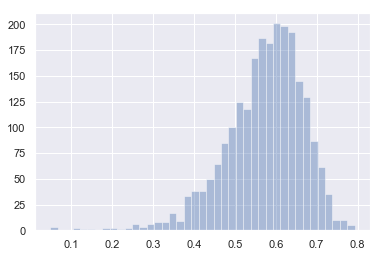

In [151]:
sns.distplot(contig_corr, kde=False)

### PCA for single bin

In [59]:
scores = pd.DataFrame(contigs_z_scores)
scores.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.530228,1.630389,1.357081,-2.160117,-0.213146,-2.040721,1.868443,0.510639,0.396471,1.816589,...,1.582653,1.743274,2.485667,-0.332713,-2.859415,0.900764,-0.631872,-0.542448,1.092351,0.122780
1,1.533157,-1.214746,1.080349,-1.450345,0.652039,-0.787795,1.866086,-1.725344,-0.845818,1.160026,...,0.779159,-0.522481,0.953206,0.010648,-1.176544,0.144527,0.527725,-0.205921,-1.280760,1.134057
2,-1.707340,1.599199,0.599345,-0.189805,0.768533,-2.960360,2.621325,-0.381237,-0.209089,1.163324,...,-0.599067,0.928226,0.197403,-1.180800,0.553819,0.725221,0.734470,-1.346893,0.293361,0.200026
3,-1.040913,1.525000,0.409385,-0.852695,0.953297,-1.790811,2.007430,-1.067513,0.390094,-0.559811,...,0.293863,-0.246033,-0.572759,-0.235475,0.615602,0.425736,0.896381,-1.053758,0.007658,0.147582
4,-2.024432,1.391611,-0.715401,1.552680,1.874493,-2.924467,-1.030705,2.502165,1.577745,-0.647754,...,0.056702,-0.088069,3.822234,0.741955,-6.245493,1.616129,0.238720,-0.811227,0.435616,0.175484


### Similarity of bins 

In [152]:
bins_path = "./test/"

all_z = []

for fasta in os.listdir(bins_path):
    
    path = bins_path+fasta
    print(path)
    
    
    contigs = SeqIO.parse(path, 'fasta')
    di_list, tri_list, tetra_list = nucl_lists()

    contigs_z_scores = []
    for record in contigs:  
        if len(record.seq) > 2500:
            for fragment in split_fragment(record.seq, opt_len(record.seq, 5000)):
                z_scores = get_z_scores(fragment, di_list, tri_list, tetra_list)
                contigs_z_scores.append(z_scores)

    contigs_z_scores = np.array(contigs_z_scores)
    contig_corr = inter_correlations(contigs_z_scores)
    
    all_z.append(contigs_z_scores)
    

./test/bin.1.fa
./test/bin.3.fa
./test/bin.2.fa
./test/bin.5.fa


In [170]:
#Make easy to handel dataframe
frames = []
for i in range(len(all_z)):
    df = pd.DataFrame(all_z[i])
    df['bin'] = i

    frames.append(df)

result = pd.concat(frames,ignore_index=True)

## PCA

In [172]:
X = result.values
labels = X[:,-1]
X = X[:,:-1]

pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

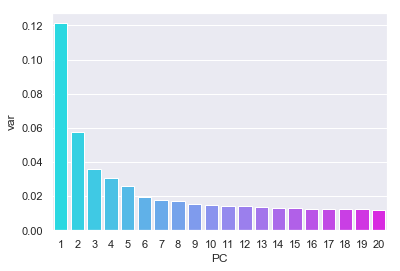

In [174]:
#Scree plot
df = pd.DataFrame({'var':pca.explained_variance_ratio_, 
                   'PC':[x+1 for x in range(len(pca.explained_variance_ratio_))]})

sns.barplot(x='PC',y="var", 
           data=df[0:20], palette='cool');

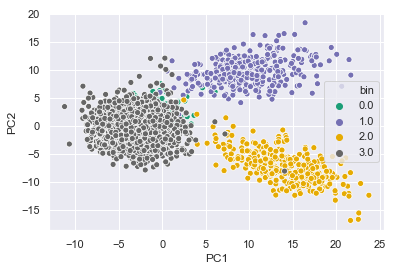

In [187]:
pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])
pca_df['bin']=labels

sns.scatterplot(x='PC1', y='PC2', hue='bin', data=pca_df, palette='Dark2')

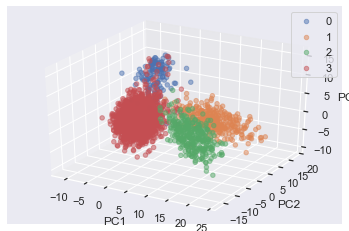

In [194]:
# 3D PCA

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

bins={}
for i in range(len(all_z)):
    sub = pca_df[pca_df['bin']==i]
    ax.scatter(sub['PC1'], sub['PC2'], sub['PC3'], 
               label=i, alpha=0.5)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.legend()
plt.show()